In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import params
import nucleation_and_growth as nandg
import feo_thermodynamics

Pr =  0.09075  Sc =  999.9999999999999


# Crystal growth following Sun et al. (2018)

The Kirkpatrick growth models assume that the process of crystal growth at an interface can be described
in terms of a diffusional equation and treated as if this was solving a bulk diffusion problem (i.e. that
the Stokes-Einstien equation holds). This seems unlikly. Fortunatly, more recent work has 
attempted to quantify and understand crystal growth in metals using atomic scale simulation. Importantly,
this is a very quick process.

Here we follow Sun et al. (2018; Nature Materials 17:881-886, https://doi.org/10.1038/s41563-018-0174-6)
who simulate crystal growth of the FCC metals Al, Ni, Cu, Ag, Pt and Pb using an embedded atom model at
temperatures from the (simulated) melting point down to undercoolings of ~300 K below the melting point in order
to understand why crystal growth for these crystals was "ultrafast". These calculations were undertaken
using LAMMPS and were not at elevated pressure. These atomic scale results were compared with three models
and an emprical fit:

1. A linear fit of growth rate againts undercooling
2. The Wilson–Frenkel model, where growth is limited by diffusion in the liquid
3. A Ginzburg–Landau approach, where growth is contolled by density fluctuations in the liquid
4. A collision rate model

All these models can be described the interaction of a kinetic and a thermodynamic term (equation 1 of Sun; S1):

$$ V(T) = k(T) \left[1 - \exp\left(\frac{\Delta\mu}{k_B T}\right)  \right],$$

where $V(T)$ is the growth rate of the crystal (normal to the 111 face) $k(T)$ is a kinetic function and
$\Delta\mu$ is the difference in the chemical potential of the solid and the liquid. This is analogous to K4,
(or K8). $k(T)$ is different for the different models:

1. $k(T) = k_0$
2. $k(T) = l\frac{6D(T)}{\gamma^2}$
3. $k(T) \propto \frac{S(K_i)}{\tau(K_i)}$
3. $k(T) \propto \sqrt{\frac{3K_B T}{M}}$

Models 1 and 4 reproduce the atomic scale data fairly well over the temperature range (see Sun et al. Fig 1).

For simplicity, I'll take model 1 and write a growth rate function.

Sun SI: https://static-content.springer.com/esm/art%3A10.1038%2Fs41563-018-0174-6/MediaObjects/41563_2018_174_MOESM1_ESM.pdf

## Fe-O mixture

From the Komabayashi thermodynamic model we can calculate $\Delta\mu$ for any combination of Fe concentration in the liquid, temperature and pressure. As we'll only consider crystalisation
of solid Fe (not FeO), $\Delta\mu = \mu_{Fe}^{solid} - \mu_{Fe}^{liquid}$, growth rate will be 
positive if the composition and temperature is below and to the Fe side of the liquidus
(crystals will grow) and negative if the composition and temperature are above or to the 
right of the liquidus (crystals will melt). As crystals grow the composition of the liquid
will become enriched in O and growth rate will decrease to zero on the liquidus (when phase
equilibrium is reached). 

In some sense $k(T)$ captures limitations to growth on the crystal surface (e.g. island
neucleation) and limitations on removal of O from the interface (diffusion). It is not
totally clear how to treat these effects but for now I'll push diffusion off to a seperate
problem and assume model 1 from above (taking $k_0$ as a parameter that relates to pure
Fe). 

The cells below show how growth velocities vary as crystalisation proceeds in a box of
fixed overall composition, temperature and pressure (ignoring the change in volume caused
by the crystalisation).

In [2]:
# A point fairly deep inside the two phase region...
t = 5000.0 # K
x = 0.9 # mol frac Fe
p = 330.0 # GPa

# Setup liquid contents and volume fractions solid
# (conserve O)
total_volume = 100**3 # cm^3
vf_solid = np.linspace(0.001, 0.9)
_, mol_vol_solid, _ = feo_thermodynamics.solid_molar_volume(1.0, p, t)
mol_vol_liquid, _, _ = feo_thermodynamics.liquid_molar_volume(x, p, t)
mol_solid =  ((vf_solid * total_volume) / mol_vol_solid) 
total_mol = (total_volume / mol_vol_solid) # is this right?
mol_frac_solid = mol_solid / total_mol

x_l =  (1.0 - x) / (1.0 - mol_frac_solid) # can this be right?



In [3]:
# Phase equilibrium (just for plotting)
eq_x_lq, eq_phi_fe, eq_phi_lq, eq_phi_feo, eq_phi_solid = feo_thermodynamics.phase_relations_molar(x, p, t)
print(eq_phi_solid)

0.5423219126276883


In [4]:
mu_fe_solid, _, _ = feo_thermodynamics.solid_free_energies(1.0, p, t)
mu_fe_liquid = feo_thermodynamics.fe_liquid_chemical_potential(x_l, p, t)
growth_velocity = nandg.sun_velocity_fit((mu_fe_solid - mu_fe_liquid)/feo_thermodynamics.avogadro, params.cu_k0, t)

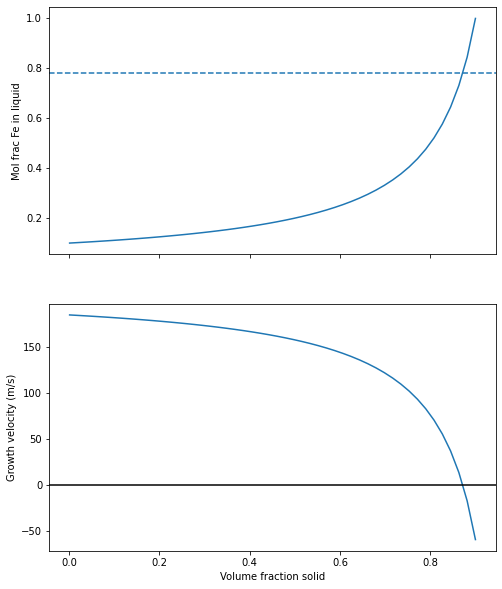

In [5]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(8,10))
ax[0].plot(vf_solid, x_l)

ax[0].axhline(eq_x_lq, ls='--')
ax[1].plot(vf_solid, growth_velocity)
ax[1].axhline(0, c='k', ls='-')

ax[1].set_xlabel('Volume fraction solid')
ax[1].set_ylabel('Growth velocity (m/s)')
ax[0].set_ylabel('Mol frac Fe in liquid')

plt.show()

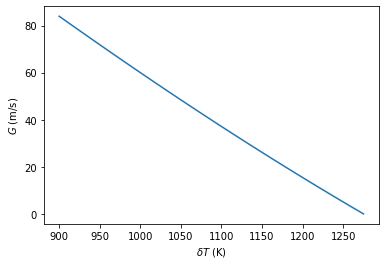

In [6]:
# OLD stuff!!!

# Calculate growth velocity as a function of temperatue 
ts_ = np.linspace(900, params.cu_tm)
dts = params.cu_tm - ts_
vs  = nandg.sun_velocity_fit(nandg.sun_d_mu(dts, params.cu_tm, params.cu_dhm), params.cu_k0, ts_)

# Plot graph - like Fig 1 of paper
fig, ax = plt.subplots()
ax.plot(ts_, vs)
#ax.plot(dts, vs)
ax.set_xlabel('$\delta T$ (K)')
ax.set_ylabel('$G$ (m/s)')
#ax.set_title('Cu growth rate, c.f. Sun et al. Fig 1c')
file2="Sun.pdf"
plt.savefig(file2, format='pdf',bbox_inches="tight")
plt.show()

# FeO nucleation

Abandon equation 2 from Davies et al. as we have the ability to calculate $g^{sl}$ explicitly
as a function of T, P and x (given some assumptions about what happens to O, discussed below).
The following is still ok:

$$ \Delta G = 4/3 \pi r^3 g^{sl} + 4 \pi r^2 \gamma,$$

$$ r_c = \frac{-2 \gamma}{g^{sl}}, $$

(negative $r_c$ implies $g^{sl}$ is positive and we are above the liquidus.)

$$ \Delta G_c = \frac{16 \pi \gamma^3}{{3 g^{sl}}^2} $$

and 

$$ I = I_0 \exp \left[\frac{-\Delta G_c}{k_B T}\right] $$

or

$$ \tau_v = \frac{1}{2 I_0} \exp \left[\frac{\Delta G_c}{k_B T}\right] $$

approximations (beyond the thermodynamic model being right) are that the forward
and backwards reaction rates at the top of the barrier are the same, that $\gamma$
can be taken as a constant, that the crystalizing solid can be described by the bulk
thermodynamics, and that the neucli are spherical.

For an FeO liquid we can calculate the energy of solid HCP Fe and a liquid of any
oxygen content. We can then write:

$$g^{sl} = p g^{solid} + q g(x_p)^{liquid} - (p+q) g(x_i)^{liquid} $$

Where $(p+q)$ moles of liquid of composition $x_i$ freeze to form $p$ moles of HCP iron and 
$q$ moles of residual liquid of composition $x_p$. $p$ can be calculated from the volume of the
critical radius and the molar volume of the solid and $x_i$ is known. The difficulty is 
calculating $q$ and $x_p$.

One approach is to say that as the critical nucleus forms the ejected oxygen becomes well mixed
in a macoscopic system. In this case $g(x_p)^{liquid} = g(x_i)^{liquid}$ and:

$$g^{sl} = g^{solid} - g(x_i)^{liquid} $$

In this approach $g(x_i)^{liquid}$ should be the chemical potential of Fe in the liquid (at $x_i$)
so we do not erroniously count the energy of the oxygen.

Alternitivly, we can imagine a small volume of liquid around the nucleus (say the radius of 
chemical fluctuations in the supercooled liquid) with the total oxygen confined within this region.
In this case we can calculate $(p + q)$ from the radius of the confinment region and $x_p$ from the
need to conserve the total oxygen content. For some radius, $x_i$ will happen to be equal to the
equilibrium oxygen content for the pressure and temperature. This may (possibly) give the minimum
$g^{sl}$ and thus the smallest $r_c$. But I'm not sure.

### Well mixed approximation

Using parameters from Davies et al.

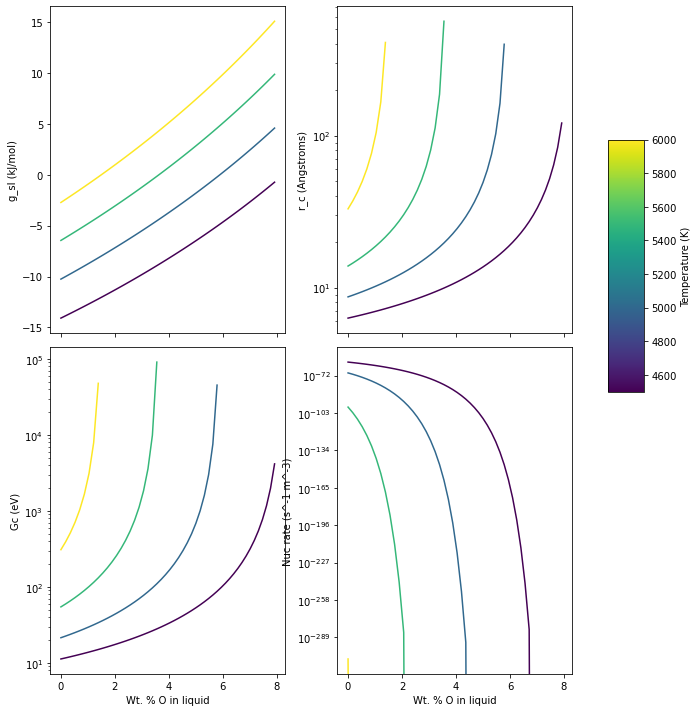

In [71]:
p = 330 # GPa
x = np.linspace(1.0, 0.7) # mol frac Fe
ts = np.array([6000, 5500, 5000, 4500])
gamma = 1.08 # J/m^2
i0 = 0.71E-48 # s^-1 m^-3

fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(10,10))
cmap=matplotlib.cm.ScalarMappable(cmap='viridis')
cmap.set_clim(vmin=min(ts), vmax=max(ts))


for t in ts:
    
    # g_sl
    _, g_fe, _ = feo_thermodynamics.solid_free_energies(x, p, t)
    g_lq = feo_thermodynamics.fe_liquid_chemical_potential(x, p, t)
    g_sl = g_fe - g_lq# J/mol
    _, mol_vol_solid, _ = feo_thermodynamics.solid_molar_volume(1.0, p, t)
    
    ax[0,0].plot(feo_thermodynamics.mass_percent_o(x), g_sl/1000,
            color=cmap.to_rgba(t))
    g_sl = (g_sl / mol_vol_solid) * 100**3 # J/m^3
    
    # r_c
    r_c = -2*gamma / g_sl
    mask = r_c<=0.0
    r_c[mask] = np.nan
    ax[0,1].plot(feo_thermodynamics.mass_percent_o(x), r_c/1E-10,
            color=cmap.to_rgba(t))
    
    # gc
    gc = (16.0 * np.pi * gamma**3) / (3.0 * g_sl**2) # in J?
    gc[mask] = np.nan
    ax[1,0].plot(feo_thermodynamics.mass_percent_o(x), 
               gc*6.242e+18, color=cmap.to_rgba(t))
    
    ax[1,1].plot(feo_thermodynamics.mass_percent_o(x), 
               i0 * np.exp(-gc / (t * params.kb)),
            color=cmap.to_rgba(t)) 

ax[1,0].set_ylabel('Gc (eV)')

ax[1,1].set_ylabel('Nuc rate (s^-1 m^-3)')
ax[1,0].set_yscale('log')
ax[0,1].set_yscale('log')
ax[1,1].set_yscale('log')  
    
ax[1,0].set_xlabel('Wt. % O in liquid')
ax[1,1].set_xlabel('Wt. % O in liquid')
ax[0,1].set_ylabel('r_c (Angstroms)')
ax[0,0].set_ylabel('g_sl (kJ/mol)')



fig.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.45, 0.05, 0.35])
cbar = fig.colorbar(cmap, cax=cbar_ax)
cbar.set_label('Temperature (K)')
plt.show()

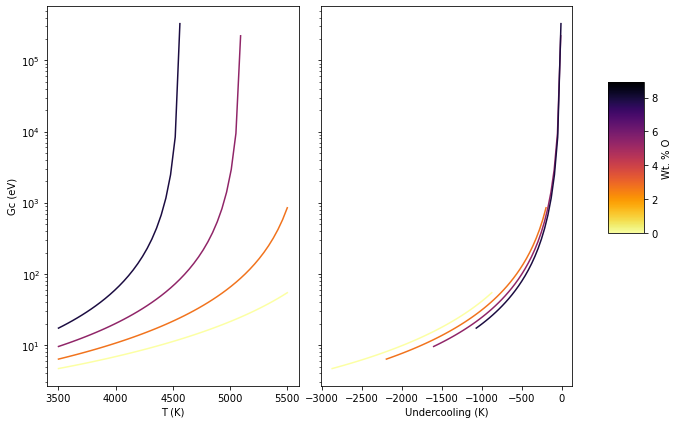

In [100]:
p = 330 # GPa
xs = np.array([1.0, 0.9, 0.8, 0.7]) # mol frac Fe
ts = np.linspace(3500, 5500)
gamma = 1.08 # J/m^2
i0 = 0.71E-48 # s^-1 m^-3

fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(10,6))

cmap=matplotlib.cm.ScalarMappable(cmap='inferno_r')
cmap.set_clim(vmin=feo_thermodynamics.mass_percent_o(max(xs)), vmax=feo_thermodynamics.mass_percent_o(min(xs))+1.0)

for x in xs:
    g_sl = np.zeros_like(ts)
    t_liquidus = feo_thermodynamics.find_liquidus(x, p)
    for i, t in enumerate(ts):
        # g_sl
        _, g_fe, _ = feo_thermodynamics.solid_free_energies(x, p, t)
        g_lq = feo_thermodynamics.fe_liquid_chemical_potential(x, p, t)
        _g_sl = g_fe - g_lq# J/mol
        _, mol_vol_solid, _ = feo_thermodynamics.solid_molar_volume(1.0, p, t)
        g_sl[i] = (_g_sl / mol_vol_solid) * 100**3 # J/m^3
        
     
    r_c = -2*gamma / g_sl
    mask = r_c<=0.0
    r_c[mask] = np.nan
    
    gc = (16.0 * np.pi * gamma**3) / (3.0 * g_sl**2) # in J?
    gc[mask] = np.nan
    
    ax[0].plot(ts, gc*6.242e+18, color=cmap.to_rgba(feo_thermodynamics.mass_percent_o(x)))
    ax[1].plot(ts-t_liquidus, gc*6.242e+18, color=cmap.to_rgba(feo_thermodynamics.mass_percent_o(x)))

ax[0].set_yscale('log')
ax[0].set_ylabel('Gc (eV)')
ax[0].set_xlabel('T (K)')
ax[1].set_yscale('log')
ax[1].set_xlabel('Undercooling (K)')

fig.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.45, 0.05, 0.35])
cbar = fig.colorbar(cmap, cax=cbar_ax)
cbar.set_label('Wt. % O')
plt.show()

## Nucleation timescale

Uses eqn 6 of https://www.sciencedirect.com/science/article/pii/S0012821X18306782

In [3]:
T_abs   = np.linspace(4500, 6500, 6)
O_abs   = np.linspace(0.01, 0.08, 6)
tN      = np.zeros([len(T_abs), len(O_abs)])
tG      = np.zeros([len(T_abs), len(O_abs)])
ttot_TO = np.zeros([len(T_abs), len(O_abs)])

rad   = 1e-6

ttot_To, tN, tG = nandg.tau_phase_TO(rad, T_abs, O_abs)

t =  4500.0
o =  0.01 dT =  -1622.3081174304798
o =  0.024 dT =  -1284.9956746700882
o =  0.038000000000000006 dT =  -962.085986363767
o =  0.05200000000000001 dT =  -650.4603236862149
o =  0.066 dT =  -347.5354260229178
o =  0.08 dT =  -51.05321515529158
t =  4900.0


/Users/andrewwalker/Code/slurry/nucleation_and_growth.py:37: RuntimeWarning: overflow encountered in exp
  tau_v = prefac * np.exp(fac)


o =  0.01 dT =  -1222.3081174304798
o =  0.024 dT =  -884.9956746700882
o =  0.038000000000000006 dT =  -562.085986363767
o =  0.05200000000000001 dT =  -250.4603236862149
o =  0.066 dT =  52.46457397708218
o =  0.08 dT =  348.9467848447084
t =  5300.0
o =  0.01 dT =  -822.3081174304798
o =  0.024 dT =  -484.9956746700882
o =  0.038000000000000006 dT =  -162.085986363767
o =  0.05200000000000001 dT =  149.5396763137851
o =  0.066 dT =  452.4645739770822
o =  0.08 dT =  748.9467848447084
t =  5700.0
o =  0.01 dT =  -422.3081174304798
o =  0.024 dT =  -84.99567467008819
o =  0.038000000000000006 dT =  237.914013636233
o =  0.05200000000000001 dT =  549.5396763137851
o =  0.066 dT =  852.4645739770822
o =  0.08 dT =  1148.9467848447084
t =  6100.0
o =  0.01 dT =  -22.308117430479797
o =  0.024 dT =  315.0043253299118
o =  0.038000000000000006 dT =  637.914013636233
o =  0.05200000000000001 dT =  949.5396763137851
o =  0.066 dT =  1252.4645739770822
o =  0.08 dT =  1548.9467848447084
t =  

In [4]:
r = np.logspace(-8,3,num=25) # few points - so slow now.
Temp = [5150,5250, 5150, 5250]
Oconc= [0.01, 0.01, 0.02, 0.02]
ttot_r = [] # List to hold results...
for i, o in zip(Temp, Oconc):
    ttot_r.append(nandg.tau_phase_r(r, i, o))

rad =  1e-08
rad =  2.8729848333536628e-08
rad =  8.25404185268019e-08
rad =  2.3713737056616554e-07
rad =  6.812920690579608e-07
rad =  1.9573417814876578e-06
rad =  5.623413251903491e-06
rad =  1.6155980984398728e-05
rad =  4.641588833612772e-05
rad =  0.0001333521432163324
rad =  0.00038311868495572853
rad =  0.001100694171252208
rad =  0.0031622776601683794
rad =  0.009085175756516862
rad =  0.026101572156825334
rad =  0.07498942093324558
rad =  0.21544346900318823
rad =  0.6189658188912597
rad =  1.7782794100389228
rad =  5.108969774506914
rad =  14.677992676220676
rad =  42.169650342858226
rad =  121.15276586285852
rad =  348.0700588428406
rad =  1000.0
rad =  1e-08
rad =  2.8729848333536628e-08
rad =  8.25404185268019e-08
rad =  2.3713737056616554e-07
rad =  6.812920690579608e-07
rad =  1.9573417814876578e-06
rad =  5.623413251903491e-06
rad =  1.6155980984398728e-05
rad =  4.641588833612772e-05
rad =  0.0001333521432163324
rad =  0.00038311868495572853
rad =  0.0011006941712522

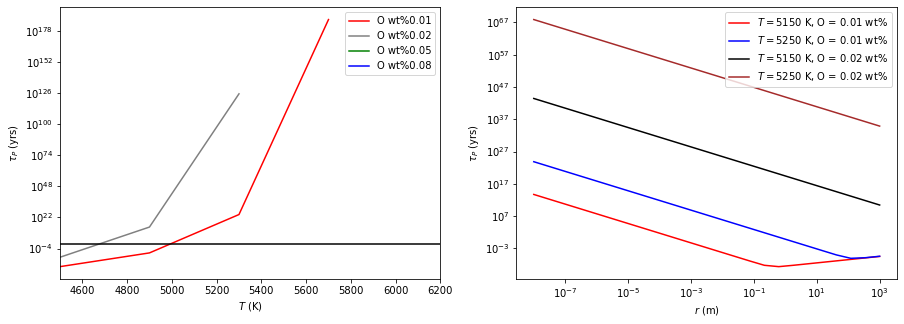

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.set_yscale('log')
ax1.set_xlabel('$T$ (K)')
ax1.set_ylabel('$\\tau_P$ (yrs)')
ax1.set_xlim([4500,6200])
ax1.plot(T_abs, tN[:,0]  , color='red'   ,label="O wt%"+str(np.round(O_abs[0],2)))
ax1.plot(T_abs, tN[:,1]  , color='grey',label="O wt%"+str(np.round(O_abs[1],2)))
ax1.plot(T_abs, tN[:,3]  , color='green' ,label="O wt%"+str(np.round(O_abs[3],2)))
ax1.plot(T_abs, tN[:,5]  , color='blue'  ,label="O wt%"+str(np.round(O_abs[5],2)))
ax1.plot(T_abs, ttot_TO[:,0], color='red'   , ls=':')
ax1.plot(T_abs, ttot_TO[:,1], color='grey', ls=':')
ax1.plot(T_abs, ttot_TO[:,4], color='green' , ls=':')
ax1.plot(T_abs, ttot_TO[:,5], color='blue'  , ls=':')
ax1.plot(T_abs, np.ones(len(T_abs)), color="black")
ax1.legend()

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('$r$ (m)')
ax2.set_ylabel('$\\tau_P$ (yrs)')
for ttr, tmp, oco, col in zip(ttot_r, Temp, Oconc, ['red', 'blue', 'black', 'brown']):
    ax2.plot(r, ttr  , color=col  , label="$T={}$ K, O = {} wt%".format(tmp, oco))
ax2.legend()

file2="Tp.pdf"
plt.savefig(file2, format='pdf',bbox_inches="tight")

plt.show()

In [8]:
# Plot some tiemscales
NT = 11
dT = np.linspace(400,900,NT)

tnuc  = np.zeros(len(dT))
tIsun = np.zeros([len(r), len(dT)])

ii = 0
for i in dT:
    tnuc[ii] = nandg.tauv(i, params.Tm) / params.Vsl / params.secinyr
    
    jj = 0 
    for j in r:
        G = nandg.sun_velocity_fit(i, params.Tm, params.cu_dhm, params.cu_k0)
        tIsun[jj,ii] = j/G/params.secinyr
        jj = jj + 1
    ii = ii + 1

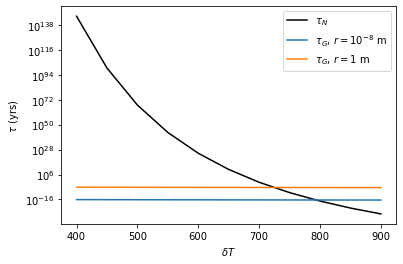

In [10]:
#Plot nucleation and growth rates as functions on dT
# DO WE NEED THIS PLOT?
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.plot(dT, tnuc       , label='$\\tau_N$'              , color='black')
ax.plot(dT, tIsun[0,:] , label='$\\tau_G$, $r=10^{-8}$ m')
ax.plot(dT, tIsun[24,:], label='$\\tau_G$, $r=1$ m')
ax.set_xlabel('$\delta T$')
ax.set_ylabel('$\\tau$ (yrs)')
ax.legend(loc=1)
file2="TgTn.pdf"
plt.savefig(file2, format='pdf',bbox_inches="tight")